In [1]:
from pyhive import hive
import pandas as pd

In [2]:
conn = hive.Connection('172.17.0.1', port=10000)

In [3]:
cursor = conn.cursor()
cursor.execute('SHOW DATABASES')
cursor.fetchall()

[('default',)]

In [4]:
cursor.execute('select * from default.tweets')


In [9]:
dataframe = pd.read_sql("SELECT * FROM default.tweets", conn)

In [10]:
dataframe.head()

,tweets.id,tweets.text,tweets.date,tweets.score
0,1467810369,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Apr,0
1,1467810672,is upset that he can't update his Facebook by ...,Apr,0
2,1467810917,@Kenichan I dived many times for the ball. Man...,Apr,0
3,1467811184,my whole body feels itchy and like its on fire,Apr,0
4,1467811193,"@nationwideclass no, it's not behaving at all....",Apr,0


In [15]:
df = pd.read_sql("DESCRIBE DATABASE EXTENDED default", conn)

In [16]:
df

,db_name,comment,location,owner_name,owner_type,parameters
0,default,Default Hive database,hdfs://namenode:8020/user/hive/warehouse,public,ROLE,


In [12]:
from pyspark.sql import SparkSession
#Create PySpark SparkSession
spark = SparkSession.builder \
    .master("local") \
    .appName("S") \
    .getOrCreate()
#Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(dataframe) 
sparkDF.printSchema()
sparkDF.show()

21/09/18 22:07:45 WARN Utils: Your hostname, DESKTOP-2N36MID resolves to a loopback address: 127.0.1.1; using 192.168.159.1 instead (on interface eth2)
21/09/18 22:07:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/09/18 22:07:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


root
 |-- tweets.id: string (nullable = true)
 |-- tweets.text: string (nullable = true)
 |-- tweets.date: string (nullable = true)
 |-- tweets.score: string (nullable = true)



21/09/18 22:09:06 WARN TaskSetManager: Stage 0 contains a task of very large size (158146 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+-----------+------------+
| tweets.id|         tweets.text|tweets.date|tweets.score|
+----------+--------------------+-----------+------------+
|1467810369|@switchfoot http:...|        Apr|           0|
|1467810672|is upset that he ...|        Apr|           0|
|1467810917|@Kenichan I dived...|        Apr|           0|
|1467811184|my whole body fee...|        Apr|           0|
|1467811193|@nationwideclass ...|        Apr|           0|
|1467811372|@Kwesidei not the...|        Apr|           0|
|1467811592|         Need a hug |        Apr|           0|
|1467811594|@LOLTrish hey  lo...|        Apr|           0|
|1467811795|@Tatiana_K nope t...|        Apr|           0|
|1467812025|@twittera que me ...|        Apr|           0|
|1467812416|spring break in p...|        Apr|           0|
|1467812579|I just re-pierced...|        Apr|           0|
|1467812723|@caregiving I cou...|        Apr|           0|
|1467812771|@octolinz16 It it...|        Apr|           

In [13]:
sparkDF.write.saveAsTable('tweets')

21/09/18 22:09:19 WARN TaskSetManager: Stage 1 contains a task of very large size (158146 KiB). The maximum recommended task size is 1000 KiB.


In [14]:
spark.sql('show databases').show()

spark.sql("show tables in default").show()
spark.catalog.listTables("default")

+---------+
|namespace|
+---------+
|  default|
+---------+

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default|   tweets|      false|
+--------+---------+-----------+



[Table(name='tweets', database='default', description=None, tableType='MANAGED', isTemporary=False)]

In [25]:
sparkDF.printSchema()

root
 |-- tweets.id: string (nullable = true)
 |-- tweets.text: string (nullable = true)
 |-- tweets.date: string (nullable = true)
 |-- tweets.score: string (nullable = true)



In [40]:
sparkDF.registerTempTable("events")

In [41]:
spark.sql("show tables in default").show()
spark.catalog.listTables("default")

+--------+---------+-----------+
|database|tableName|isTemporary|
+--------+---------+-----------+
| default|   tweets|      false|
|        |   events|       true|
+--------+---------+-----------+



[Table(name='tweets', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='events', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [48]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *

In [103]:
 spark.sql("SELECT `tweets.date` from events").show(5)

21/09/19 00:47:11 WARN TaskSetManager: Stage 91 contains a task of very large size (158146 KiB). The maximum recommended task size is 1000 KiB.


+-----------+
|tweets.date|
+-----------+
|        Apr|
|        Apr|
|        Apr|
|        Apr|
|        Apr|
+-----------+
only showing top 5 rows



In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
from pyspark.sql import SQLContext
df1 = spark.sql("SELECT `tweets.score` , count(*) as count from tweets group by `tweets.score`").toPandas()

import numpy as np

df1['tweets.score'] = df1['tweets.score'].replace('None', np.nan)
df1 = df1.dropna(axis=0, subset=['tweets.score'])


df1['sentiment'] = df1.apply(lambda row: 'negative' if row['tweets.score'] == '0' else 'positive', axis = 1)
df1 = df1.drop(['tweets.score'], axis = 1)

In [97]:
df1

,count,sentiment
0,799955,negative
2,799971,positive


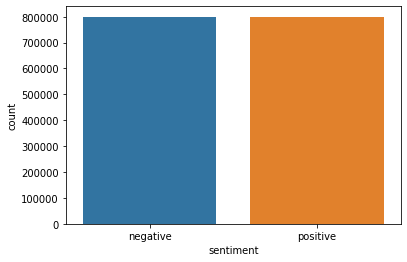

In [100]:
ax = sns.barplot(x="sentiment", y="count", data=df1)

In [109]:
df1 = spark.sql("SELECT `tweets.date` , count(*) as count from tweets group by `tweets.date`").toPandas()

df1['tweets.date'] = df1['tweets.date'].replace('None', np.nan)
df1 = df1.dropna(axis=0, subset=['tweets.date'])



In [ ]:
df1

In [126]:
df1 = spark.sql("SELECT `tweets.text` from tweets where `tweets.score` = 0" ).toPandas()
df2 = spark.sql("SELECT `tweets.text` from tweets where `tweets.score` = 4").toPandas()

In [127]:
df1

,tweets.text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,is upset that he can't update his Facebook by ...
2,@Kenichan I dived many times for the ball. Man...
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all...."
...,...
799950,Sick Spending my day laying in bed listening ...
799951,Gmail is down?
799952,rest in peace Farrah! So sad
799953,@Eric_Urbane Sounds like a rival is flagging y...


(-0.5, 799.5, 599.5, -0.5)

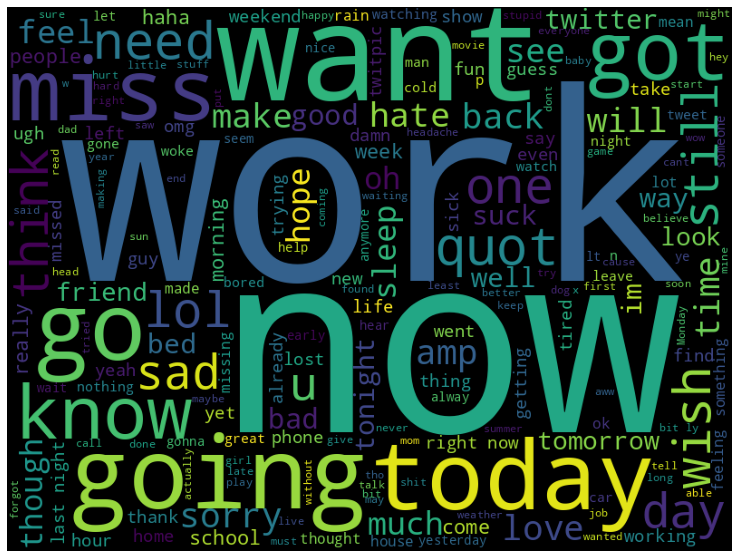

In [129]:
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(df1["tweets.text"]))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.axis('off')

(-0.5, 799.5, 599.5, -0.5)

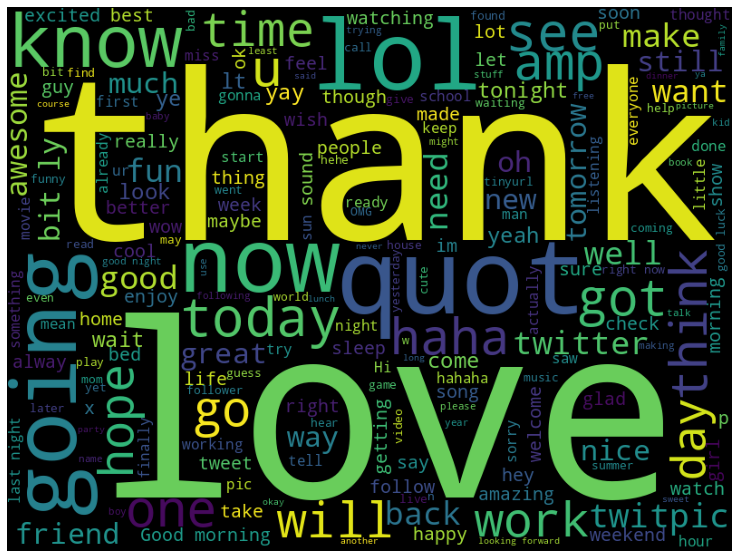

In [130]:
cloud = WordCloud(width=800, height=600).generate(" ".join(df2["tweets.text"]))
plt.figure(figsize=(15,10))
plt.imshow(cloud)
plt.axis('off')

In [64]:
spark.sql("select * from events").show(5)

21/09/19 00:02:33 WARN TaskSetManager: Stage 26 contains a task of very large size (158146 KiB). The maximum recommended task size is 1000 KiB.


+----------+--------------------+-----------+------------+
| tweets.id|         tweets.text|tweets.date|tweets.score|
+----------+--------------------+-----------+------------+
|1467810369|@switchfoot http:...|        Apr|           0|
|1467810672|is upset that he ...|        Apr|           0|
|1467810917|@Kenichan I dived...|        Apr|           0|
|1467811184|my whole body fee...|        Apr|           0|
|1467811193|@nationwideclass ...|        Apr|           0|
+----------+--------------------+-----------+------------+
only showing top 5 rows



In [67]:
spark.sql("select `tweets.id` from events").show(5)

21/09/19 00:03:54 WARN TaskSetManager: Stage 28 contains a task of very large size (158146 KiB). The maximum recommended task size is 1000 KiB.


+----------+
| tweets.id|
+----------+
|1467810369|
|1467810672|
|1467810917|
|1467811184|
|1467811193|
+----------+
only showing top 5 rows

